In [ ]:
%%bash
# Colab cell (bash)
# Install core libs. Restart runtime if needed for some large libs.
pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install -q diffusers transformers accelerate datasets ftfy safetensors
pip install -q pillow matplotlib tqdm einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Colab cell (python)
import os, math, random, time, json
from pathlib import Path
import torch, torchvision
from torchvision import transforms, datasets, utils
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# create directories
base = Path("/content")
data_dir = base/"animals10"
proc_dir = base/"processed_data"
out_dir = base/"outputs"
for sub in ["VAE","GAN","Diffusion","Transformer","comparison","checkpoints"]:    (out_dir/sub).mkdir(parents=True, exist_ok=True)
proc_dir.mkdir(parents=True, exist_ok=True)


Device: cuda


In [ ]:
!pip install -q torch torchvision torchaudio diffusers transformers accelerate datasets matplotlib tqdm pillow einops


In [ ]:
import torch, torchvision
from torch import nn, optim
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import os
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device in use:", device)

base = Path("/content")
proc_dir = base/"processed_data"
out_dir = base/"outputs"

for sub in ["VAE","GAN","Diffusion","Transformer","comparison","checkpoints"]:
    (out_dir/sub).mkdir(parents=True, exist_ok=True)


✅ Device in use: cuda


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!unzip -q "/content/archive (4).zip" -d /content/animals10


unzip:  cannot find or open /content/archive (4).zip, /content/archive (4).zip.zip or /content/archive (4).zip.ZIP.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json


{"username":"siddhibambal","key":"d4e140ee620dff11959b0bf957758bf4"}

In [ ]:
!ls /content/animals10


ls: cannot access '/content/animals10': No such file or directory


In [ ]:
!kaggle datasets list -s animals10 | head -5


ref                                           title                                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------  -------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
alessiocorrado99/animals10                    Animals-10                                     614087302  2019-12-12 20:46:33.797000         105679       1135  1.0              
paulbombay/animals10                          ANIMALS10                                      614309345  2024-04-05 14:12:00.990000             39          0  0.125            
kanglinxu/animal-10-updated                   Animal-10-Updated                              614626544  2024-03-21 19:37:48.913000             36          0  0.5              


In [ ]:
!rm -rf /content/animals10
!mkdir -p /content/animals10
!kaggle datasets download -d alessiocorrado99/animals10 -p /content/animals10
!unzip -q /content/animals10/animals10.zip -d /content/animals10
!ls -R /content/animals10 | head -40


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 95% 558M/586M [00:01<00:00, 318MB/s]
100% 586M/586M [00:03<00:00, 175MB/s]
/content/animals10:
animals10.zip
raw-img
translate.py

/content/animals10/raw-img:
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo

/content/animals10/raw-img/cane:
OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg
OIP-00zvckpZ8XDEzk-Fv4HjkQHaGL.jpeg
OIP-0261T_DaSKSIDaRxrLjL8gHaGD.jpeg
OIP-02OsWT9t46zXPceBxMicNQAAAA.jpeg
OIP-036LqzhKXwF9eUWycl2V_QHaFt.jpeg
OIP-06txpJjbByyhAlbGkpSimAHaE8.jpeg
OIP-08Xf8bQxZmCDI_CozSO-YgHaH1.jpeg
OIP-0977rkGtQ_PPflLXiMRRYAHaFM.jpeg
OIP-09znoxk9htqGbe5yWTj1TAHaHa.jpeg
OIP-0a0_6W9xqdTrLnXcL8haUgHaLH.jpeg
OIP-0aPTy5pR8zwqdi5jabdxjwHaGL.jpeg
OIP-0B2H2VPu9neVWW7TtvJlPAAAAA.jpeg
OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg
OIP-0cKVI1PLYxC2MlqoYwMw4gHaHa.jpeg
OIP-0CmAiR3-B-VLurayKj2mwAHaE8.jpeg
OIP-0cMunZ5IpSFGRbH_vYFvXgHaJ3.jpeg
OIP-0cwqK_pId75Pu0YLQq7HwgHaKj.jpeg
OIP-0cYdzGqi1lvZQkk0Hy0GGAHaIu.

✅ Total images loaded: 26179
✅ Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


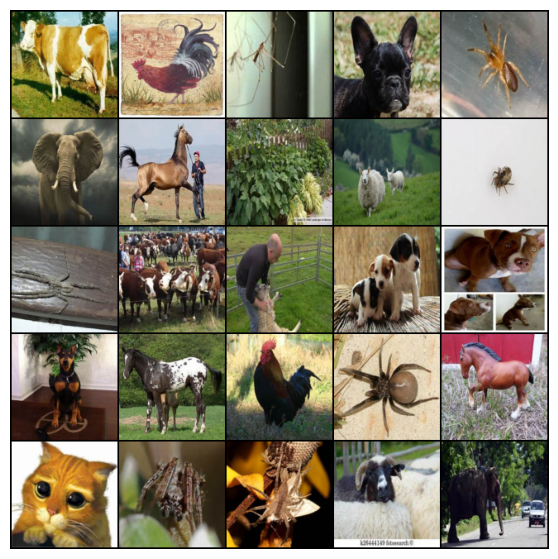

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Preprocessing: resize, normalize to [0, 1]
tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    # Normalize to [0, 1]
    transforms.Normalize([0.0]*3, [1.0]*3)
])

# Correct dataset path
dataset = datasets.ImageFolder(root="/content/animals10/raw-img", transform=tf)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"✅ Total images loaded: {len(dataset)}")
print(f"✅ Classes: {dataset.classes}")

# Show sample batch
imgs, labels = next(iter(loader))
grid = make_grid(imgs[:25], nrow=5, normalize=True)
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# -------------------------------
# 🔹 Sampling layer
# -------------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

In [ ]:
# ===========================================
# ⚡ Memory-Optimized Vision Transformer Classifier
# Dataset: Animals10
# Safe for Colab (no RAM overflow)
# ===========================================

import os, json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------------------
# ⚙️ Hyperparams (lighter for Colab)
# ---------------------------
IMG = 96          # reduced from 128
PATCH = 16
EMB = 128         # reduced from 256
HEADS = 4
MLP = 256         # reduced from 512
DEPTH = 4
BATCH = 16        # reduced from 32
EPOCHS = 100
DATA = "/content/animals10/raw-img"
OUT = "/content/transformer_animals_h5"
os.makedirs(OUT, exist_ok=True)

AUTO = tf.data.AUTOTUNE

# ---------------------------
# ✅ Mixed Precision (speeds up + lowers memory)
# ---------------------------
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("⚠️ Mixed precision not enabled:", e)

# ---------------------------
# 🔹 Utility Layer
# ---------------------------
class GetItem(layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index
    def call(self, inputs):
        return inputs[:, self.index]
    def get_config(self):
        config = super().get_config()
        config.update({"index": self.index})
        return config

# ---------------------------
# 🧠 Dataset Load (80/20 Split)
# ---------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG, IMG),
    batch_size=BATCH
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG, IMG),
    batch_size=BATCH
)

class_names = train_ds.class_names
json.dump(class_names, open(f"{OUT}/classes.json", "w"))
nclass = len(class_names)
print(f"✅ Loaded {nclass} classes:", class_names)

# ---------------------------
# ⚡ Dataset Optimization
# ---------------------------
norm = layers.Rescaling(1/255.)

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (norm(x), y), num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(256)  # smaller buffer = less RAM
    # Cache on disk instead of RAM
    cache_path = "/content/cache_train" if shuffle else "/content/cache_val"
    ds = ds.cache(cache_path).prefetch(AUTO)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds, shuffle=False)

# ---------------------------
# 🧩 Vision Transformer Components
# ---------------------------
N_PATCH = (IMG // PATCH) ** 2

class PatchExtract(layers.Layer):
    def call(self, images):
        patches = tf.image.extract_patches(
            images,
            sizes=[1, PATCH, PATCH, 1],
            strides=[1, PATCH, PATCH, 1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])
        return patches

class PatchEncode(layers.Layer):
    def __init__(self, n, d):
        super().__init__()
        self.n = n
        self.d = d
        self.proj = layers.Dense(d)
    def build(self, input_shape):
        dtype = self.compute_dtype
        self.cls = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.d),
            initializer="zeros",
            trainable=True,
            dtype=dtype
        )
        self.pos = self.add_weight(
            name="pos_embed",
            shape=(1, self.n + 1, self.d),
            initializer=keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
            dtype=dtype
        )
        super().build(input_shape)
    def call(self, x):
        x = self.proj(x)
        cls = tf.broadcast_to(self.cls, [tf.shape(x)[0], 1, tf.shape(x)[-1]])
        x = tf.concat([cls, x], axis=1)
        return x + self.pos

def transformer_block(x):
    h = layers.LayerNormalization()(x)
    h = layers.MultiHeadAttention(num_heads=HEADS, key_dim=EMB)(h, h)
    x = layers.Add()([x, h])

    h = layers.LayerNormalization()(x)
    h = layers.Dense(MLP, activation="gelu")(h)
    h = layers.Dense(EMB)(h)
    return layers.Add()([x, h])

# ---------------------------
# 🏗️ Build Model
# ---------------------------
def build_model():
    inp = layers.Input((IMG, IMG, 3))
    x = PatchExtract()(inp)
    x = PatchEncode(N_PATCH, EMB)(x)
    for _ in range(DEPTH):
        x = transformer_block(x)
    x = layers.LayerNormalization()(x)
    cls = GetItem(index=0)(x)
    out = layers.Dense(nclass, activation="softmax", dtype='float32')(cls)
    return keras.Model(inp, out)

model = build_model()
model.summary()

# ---------------------------
# ⚡ Compile
# ---------------------------
opt = keras.optimizers.Adam(3e-4)
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ---------------------------
# 💾 Callbacks
# ---------------------------
class SaveEvery10Epoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            path = os.path.join(OUT, f"epoch_{epoch+1}.h5")
            self.model.save(path)
            print(f"✅ Saved model: {path}")

checkpoint_best = keras.callbacks.ModelCheckpoint(
    os.path.join(OUT, "best_val_model.h5"),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

csv_logger = keras.callbacks.CSVLogger(os.path.join(OUT, "training_log.csv"))
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

callbacks = [SaveEvery10Epoch(), checkpoint_best, csv_logger, reduce_lr]

# ---------------------------
# 🚀 Train
# ---------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ---------------------------
# 🎯 Final Save
# ---------------------------
final_path = os.path.join(OUT, "final_transformer.h5")
model.save(final_path)
print(f"✅ Final model saved at: {final_path}")


✅ Mixed precision enabled: <DTypePolicy "mixed_float16">
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
✅ Loaded 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, None, 768) │          0 │ input_layer[0][0] │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encode        │ (None, 37, 128)   │    103,296 │ patch_extract[0]… │
│ (PatchEncode)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 37, 128)   │        256 │ patch_encode[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 37, 128)   │          0 │ patch_encode[0][… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 37, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 37, 128)   │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 37, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 37, 128)   │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 37, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 37, 128)   │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 37, 128)   │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,425,802 (5.43 MB)

 Trainable params: 1,425,802 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2018 - loss: 2.2391
Epoch 1: val_accuracy improved from -inf to 0.28768, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.2019 - loss: 2.2389 - val_accuracy: 0.2877 - val_loss: 2.0339 - learning_rate: 3.0000e-04
Epoch 2/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2976 - loss: 1.9875
Epoch 2: val_accuracy improved from 0.28768 to 0.33715, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2976 - loss: 1.9873 - val_accuracy: 0.3372 - val_loss: 1.8912 - learning_rate: 3.0000e-04
Epoch 3/100
1307/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3330 - loss: 1.8794
Epoch 3: val_accuracy improved from 0.33715 to 0.36065, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3331 - loss: 1.8793 - val_accuracy: 0.3606 - val_loss: 1.8363 - learning_rate: 3.0000e-04
Epoch 4/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3585 - loss: 1.8091
Epoch 4: val_accuracy improved from 0.36065 to 0.36619, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3585 - loss: 1.8091 - val_accuracy: 0.3662 - val_loss: 1.8017 - learning_rate: 3.0000e-04
Epoch 5/100
1303/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3845 - loss: 1.7473
Epoch 5: val_accuracy improved from 0.36619 to 0.37249, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3845 - loss: 1.7472 - val_accuracy: 0.3725 - val_loss: 1.7696 - learning_rate: 3.0000e-04
Epoch 6/100
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4025 - loss: 1.6927
Epoch 6: val_accuracy improved from 0.37249 to 0.38797, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4025 - loss: 1.6927 - val_accuracy: 0.3880 - val_loss: 1.7365 - learning_rate: 3.0000e-04
Epoch 7/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4243 - loss: 1.6411
Epoch 7: val_accuracy improved from 0.38797 to 0.41490, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4244 - loss: 1.6410 - val_accuracy: 0.4149 - val_loss: 1.6807 - learning_rate: 3.0000e-04
Epoch 8/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4360 - loss: 1.5961
Epoch 8: val_accuracy improved from 0.41490 to 0.42980, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4360 - loss: 1.5960 - val_accuracy: 0.4298 - val_loss: 1.6526 - learning_rate: 3.0000e-04
Epoch 9/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4558 - loss: 1.5488
Epoch 9: val_accuracy improved from 0.42980 to 0.44604, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4558 - loss: 1.5488 - val_accuracy: 0.4460 - val_loss: 1.6300 - learning_rate: 3.0000e-04
Epoch 10/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4742 - loss: 1.5088

✅ Saved model: /content/transformer_animals_h5/epoch_10.h5

Epoch 10: val_accuracy improved from 0.44604 to 0.44661, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4742 - loss: 1.5087 - val_accuracy: 0.4466 - val_loss: 1.6325 - learning_rate: 3.0000e-04
Epoch 11/100
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4836 - loss: 1.4703
Epoch 11: val_accuracy improved from 0.44661 to 0.44947, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4836 - loss: 1.4703 - val_accuracy: 0.4495 - val_loss: 1.6129 - learning_rate: 3.0000e-04
Epoch 12/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4937 - loss: 1.4379
Epoch 12: val_accuracy improved from 0.44947 to 0.45444, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4937 - loss: 1.4379 - val_accuracy: 0.4544 - val_loss: 1.6117 - learning_rate: 3.0000e-04
Epoch 13/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5079 - loss: 1.4004
Epoch 13: val_accuracy did not improve from 0.45444
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5079 - loss: 1.4003 - val_accuracy: 0.4487 - val_loss: 1.6434 - learning_rate: 3.0000e-04
Epoch 14/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5236 - loss: 1.3664
Epoch 14: val_accuracy did not improve from 0.45444
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5236 - loss: 1.3664 - val_accuracy: 0.4543 - val_loss: 1.6635 - learning_rate: 3.0000e-04
Epoch 15/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5315 - loss: 1.3352
Epoch 15: val_accuracy improved from 0.45444 to 0.45540, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5315 - loss: 1.3352 - val_accuracy: 0.4554 - val_loss: 1.6400 - learning_rate: 3.0000e-04
Epoch 16/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5473 - loss: 1.3014
Epoch 16: val_accuracy improved from 0.45540 to 0.46552, saving model to /content/transformer_animals_h5/best_val_model.h5


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5473 - loss: 1.3014 - val_accuracy: 0.4655 - val_loss: 1.6223 - learning_rate: 3.0000e-04
Epoch 17/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5572 - loss: 1.2705
Epoch 17: val_accuracy did not improve from 0.46552
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5572 - loss: 1.2705 - val_accuracy: 0.4550 - val_loss: 1.6559 - learning_rate: 3.0000e-04
Epoch 18/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5706 - loss: 1.2327
Epoch 18: val_accuracy did not improve from 0.46552

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5706 - loss: 1.2327 - val_accuracy: 0.4600 - val_loss: 1.6442 - learning_rate: 3.0000e-04
Epoch 19/100
1302/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5966 - loss: 1.1661
Epoch 19: val_accuracy improved from 0.46552 to 0.47545, saving model to /content/transformer_animals_h5

1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5967 - loss: 1.1658 - val_accuracy: 0.4755 - val_loss: 1.6546 - learning_rate: 1.5000e-04
Epoch 20/100
1302/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6330 - loss: 1.0653

✅ Saved model: /content/transformer_animals_h5/epoch_20.h5

Epoch 20: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6331 - loss: 1.0651 - val_accuracy: 0.4600 - val_loss: 1.7109 - learning_rate: 1.5000e-04
Epoch 21/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 1.0025
Epoch 21: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6562 - loss: 1.0024 - val_accuracy: 0.4577 - val_loss: 1.7637 - learning_rate: 1.5000e-04
Epoch 22/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6776 - loss: 0.9440
Epoch 22: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6776 - loss: 0.9440 - val_accuracy: 0.4546 - val_loss: 1.8309 - learning_rate: 1.5000e-04
Epoch 23/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6946 - loss: 0.8963
Epoch 23: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━

✅ Saved model: /content/transformer_animals_h5/epoch_30.h5

Epoch 30: val_accuracy did not improve from 0.47545

Epoch 30: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8239 - loss: 0.5586 - val_accuracy: 0.4537 - val_loss: 2.2573 - learning_rate: 7.5000e-05
Epoch 31/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8252 - loss: 0.5438
Epoch 31: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8252 - loss: 0.5438 - val_accuracy: 0.4651 - val_loss: 2.2552 - learning_rate: 3.7500e-05
Epoch 32/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8413 - loss: 0.5056
Epoch 32: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8413 - loss: 0.5056 - val_accuracy: 0.4684 - val_loss: 2.3118 - learning_rate: 3.7500e-05
Epoch 33/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8578 - loss

✅ Saved model: /content/transformer_animals_h5/epoch_40.h5

Epoch 40: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9133 - loss: 0.3237 - val_accuracy: 0.4625 - val_loss: 2.6855 - learning_rate: 1.8750e-05
Epoch 41/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9201 - loss: 0.3076
Epoch 41: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9201 - loss: 0.3076 - val_accuracy: 0.4613 - val_loss: 2.7286 - learning_rate: 1.8750e-05
Epoch 42/100
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9266 - loss: 0.2924
Epoch 42: val_accuracy did not improve from 0.47545

Epoch 42: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9266 - loss: 0.2924 - val_accuracy: 0.4617 - val_loss: 2.7725 - learning_rate: 1.8750e-05
Epoch 43/100
1307/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9229 - loss:

✅ Saved model: /content/transformer_animals_h5/epoch_50.h5

Epoch 50: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9409 - loss: 0.2470 - val_accuracy: 0.4607 - val_loss: 2.9111 - learning_rate: 4.6875e-06
Epoch 51/100
1303/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9440 - loss: 0.2408
Epoch 51: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9439 - loss: 0.2408 - val_accuracy: 0.4609 - val_loss: 2.9235 - learning_rate: 4.6875e-06
Epoch 52/100
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9461 - loss: 0.2351
Epoch 52: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9461 - loss: 0.2351 - val_accuracy: 0.4604 - val_loss: 2.9375 - learning_rate: 4.6875e-06
Epoch 53/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9478 - loss: 0.2302
Epoch 53: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━

✅ Saved model: /content/transformer_animals_h5/epoch_60.h5

Epoch 60: val_accuracy did not improve from 0.47545

Epoch 60: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9521 - loss: 0.2148 - val_accuracy: 0.4575 - val_loss: 3.0088 - learning_rate: 2.3438e-06
Epoch 61/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9488 - loss: 0.2189
Epoch 61: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9488 - loss: 0.2189 - val_accuracy: 0.4577 - val_loss: 3.0149 - learning_rate: 1.1719e-06
Epoch 62/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9515 - loss: 0.2137
Epoch 62: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9515 - loss: 0.2137 - val_accuracy: 0.4571 - val_loss: 3.0181 - learning_rate: 1.1719e-06
Epoch 63/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9529 - loss

✅ Saved model: /content/transformer_animals_h5/epoch_70.h5

Epoch 70: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9558 - loss: 0.2042 - val_accuracy: 0.4583 - val_loss: 3.0408 - learning_rate: 5.8594e-07
Epoch 71/100
1308/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9562 - loss: 0.2035
Epoch 71: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9562 - loss: 0.2035 - val_accuracy: 0.4592 - val_loss: 3.0428 - learning_rate: 5.8594e-07
Epoch 72/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9561 - loss: 0.2028
Epoch 72: val_accuracy did not improve from 0.47545

Epoch 72: ReduceLROnPlateau reducing learning rate to 2.9296876391526894e-07.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9561 - loss: 0.2028 - val_accuracy: 0.4585 - val_loss: 3.0448 - learning_rate: 5.8594e-07
Epoch 73/100
1306/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9555 - loss

✅ Saved model: /content/transformer_animals_h5/epoch_80.h5

Epoch 80: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9569 - loss: 0.1998 - val_accuracy: 0.4613 - val_loss: 3.0520 - learning_rate: 1.4648e-07
Epoch 81/100
1303/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9570 - loss: 0.1995
Epoch 81: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9570 - loss: 0.1995 - val_accuracy: 0.4613 - val_loss: 3.0526 - learning_rate: 1.4648e-07
Epoch 82/100
1302/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9570 - loss: 0.1992
Epoch 82: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9570 - loss: 0.1992 - val_accuracy: 0.4613 - val_loss: 3.0532 - learning_rate: 1.4648e-07
Epoch 83/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9570 - loss: 0.1990
Epoch 83: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━

✅ Saved model: /content/transformer_animals_h5/epoch_90.h5

Epoch 90: val_accuracy did not improve from 0.47545

Epoch 90: ReduceLROnPlateau reducing learning rate to 3.662109548940862e-08.
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9576 - loss: 0.1981 - val_accuracy: 0.4611 - val_loss: 3.0555 - learning_rate: 7.3242e-08
Epoch 91/100
1304/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9578 - loss: 0.1981
Epoch 91: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9578 - loss: 0.1981 - val_accuracy: 0.4613 - val_loss: 3.0556 - learning_rate: 3.6621e-08
Epoch 92/100
1305/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9577 - loss: 0.1980
Epoch 92: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9577 - loss: 0.1980 - val_accuracy: 0.4609 - val_loss: 3.0559 - learning_rate: 3.6621e-08
Epoch 93/100
1307/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9579 - loss:

✅ Saved model: /content/transformer_animals_h5/epoch_100.h5

Epoch 100: val_accuracy did not improve from 0.47545
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9580 - loss: 0.1977 - val_accuracy: 0.4617 - val_loss: 3.0564 - learning_rate: 1.8311e-08


✅ Final model saved at: /content/transformer_animals_h5/final_transformer.h5


✅ Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


✅ Model loaded and ready for multiple image inference!


Saving ludemeula-fernandes-451948-unsplash.jpg to ludemeula-fernandes-451948-unsplash.jpg
Saving marko-blazevic-219788-unsplash.jpg to marko-blazevic-219788-unsplash.jpg
Saving max-boettinger-486490-unsplash.jpg to max-boettinger-486490-unsplash.jpg
Saving mikhail-vasilyev-34524-unsplash.jpg to mikhail-vasilyev-34524-unsplash.jpg


📸 ludemeula-fernandes-451948-unsplash.jpg → gallina (37.3%)
📸 marko-blazevic-219788-unsplash.jpg → ragno (56.3%)
📸 max-boettinger-486490-unsplash.jpg → cane (28.2%)
📸 mikhail-vasilyev-34524-unsplash.jpg → ragno (22.0%)


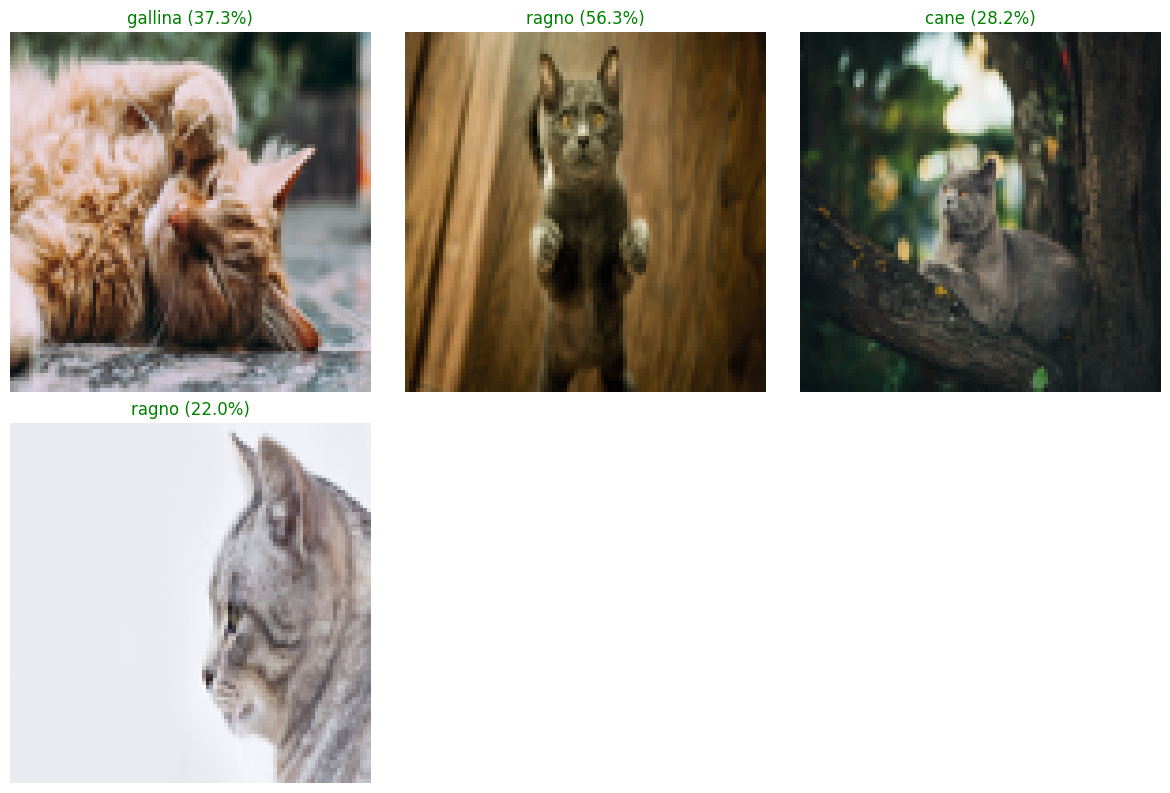

In [ ]:
# ===========================================
# 🧠 Batch Image Prediction — Vision Transformer (Multiple Inputs)
# ===========================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, json, math

# ---------------------------
# 🔹 Paths + Config
# ---------------------------
OUT = "/content/transformer_animals_h5"
MODEL_PATH = os.path.join(OUT, "best_val_model.h5")
IMG_SIZE = 96

# ---------------------------
# 🧠 Load Class Names
# ---------------------------
with open(f"{OUT}/classes.json", "r") as f:
    class_names = json.load(f)
print("✅ Classes:", class_names)

# ---------------------------
# ⚙️ Custom Layers (needed to load model)
# ---------------------------
class GetItem(layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index
    def call(self, inputs):
        return inputs[:, self.index]

class PatchExtract(layers.Layer):
    def call(self, images):
        PATCH = 16
        patches = tf.image.extract_patches(
            images,
            sizes=[1, PATCH, PATCH, 1],
            strides=[1, PATCH, PATCH, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])

class PatchEncode(layers.Layer):
    def __init__(self, n=36, d=128, **kwargs):
        super().__init__(**kwargs)
        self.n = n
        self.d = d
        self.proj = layers.Dense(d)
    def build(self, input_shape):
        dtype = self.compute_dtype
        self.cls = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.d),
            initializer="zeros",
            trainable=True,
            dtype=dtype
        )
        self.pos = self.add_weight(
            name="pos_embed",
            shape=(1, self.n + 1, self.d),
            initializer=keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
            dtype=dtype
        )
        super().build(input_shape)
    def call(self, x):
        x = self.proj(x)
        cls = tf.broadcast_to(self.cls, [tf.shape(x)[0], 1, tf.shape(x)[-1]])
        x = tf.concat([cls, x], axis=1)
        return x + self.pos

# ---------------------------
# 🧩 Load Model
# ---------------------------
model = keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "GetItem": GetItem,
        "PatchExtract": PatchExtract,
        "PatchEncode": PatchEncode
    }
)
print("✅ Model loaded and ready for multiple image inference!")

# ---------------------------
# 📤 Upload Multiple Images
# ---------------------------
from google.colab import files
uploaded = files.upload()

# ---------------------------
# 🔍 Process + Predict Each Image
# ---------------------------
all_preds = []
all_imgs = []
all_titles = []

for fname in uploaded.keys():
    img_path = f"/content/{fname}"
    img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    # Predict
    preds = model.predict(arr, verbose=0)
    pred_idx = np.argmax(preds[0])
    confidence = preds[0][pred_idx] * 100

    result_text = f"{class_names[pred_idx]} ({confidence:.1f}%)"
    print(f"📸 {fname} → {result_text}")

    all_preds.append(pred_idx)
    all_imgs.append(np.array(img))
    all_titles.append(result_text)

# ---------------------------
# 🖼️ Display All Predictions in Grid
# ---------------------------
num_images = len(all_imgs)
cols = 3
rows = math.ceil(num_images / cols)

plt.figure(figsize=(12, 4 * rows))
for i, (img, title) in enumerate(zip(all_imgs, all_titles)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(title, color="green", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


✅ Loaded 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


✅ Model loaded successfully!
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
328/328 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.4716 - loss: 1.6626

✅ Validation Accuracy: 47.55%
✅ Validation Loss: 1.6546


328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


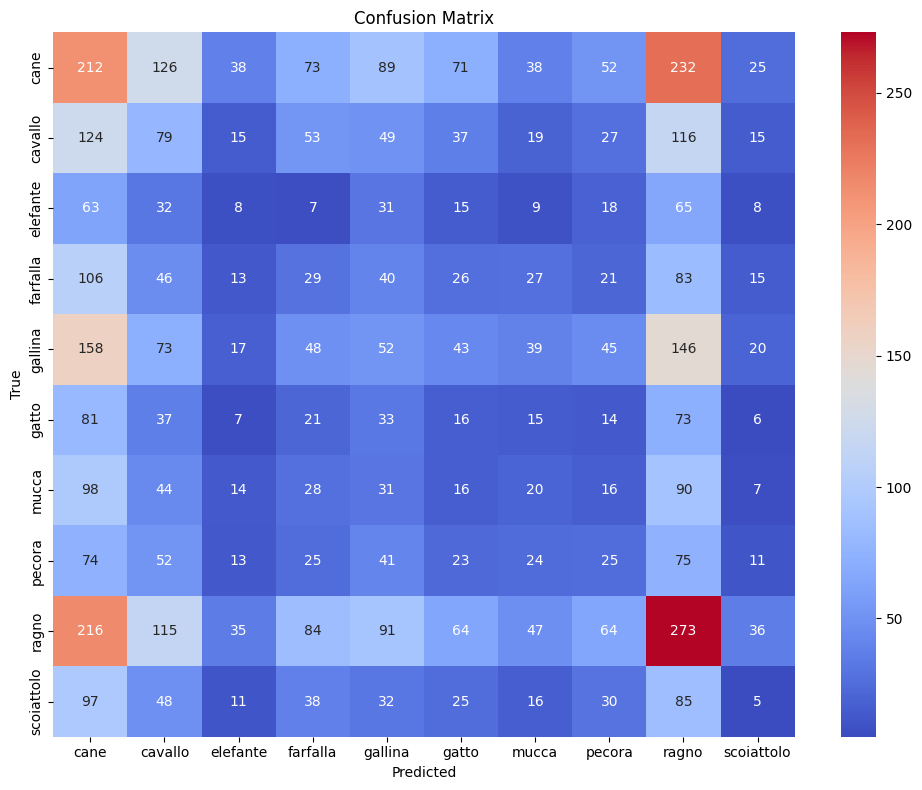

,precision,recall,f1-score,support
cane,0.172498,0.221757,0.194050,956.000000
cavallo,0.121166,0.147940,0.133221,534.000000
elefante,0.046784,0.031250,0.037471,256.000000
farfalla,0.071429,0.071429,0.071429,406.000000
gallina,0.106339,0.081123,0.092035,641.000000
gatto,0.047619,0.052805,0.050078,303.000000
mucca,0.078740,0.054945,0.064725,364.000000
pecora,0.080128,0.068871,0.074074,363.000000
ragno,0.220517,0.266341,0.241273,1025.000000
scoiattolo,0.033784,0.012920,0.018692,387.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


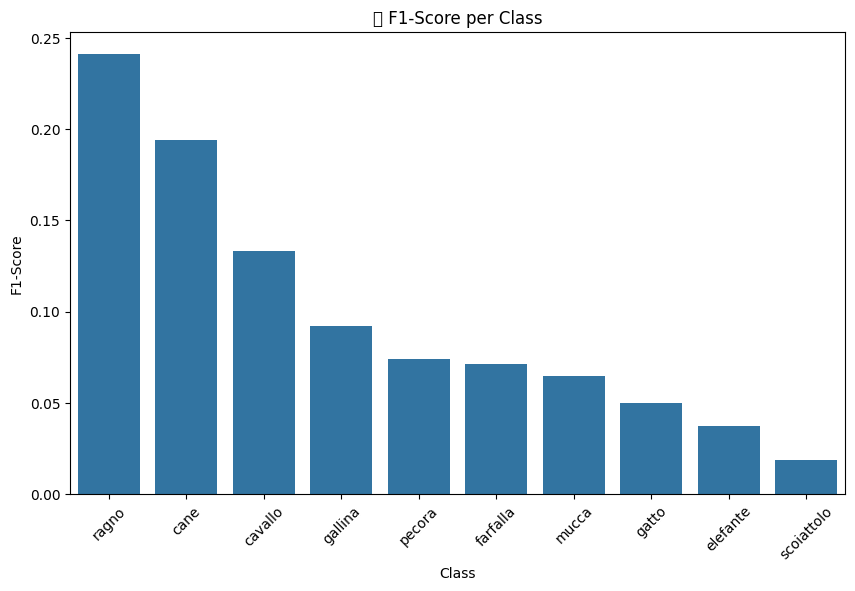

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


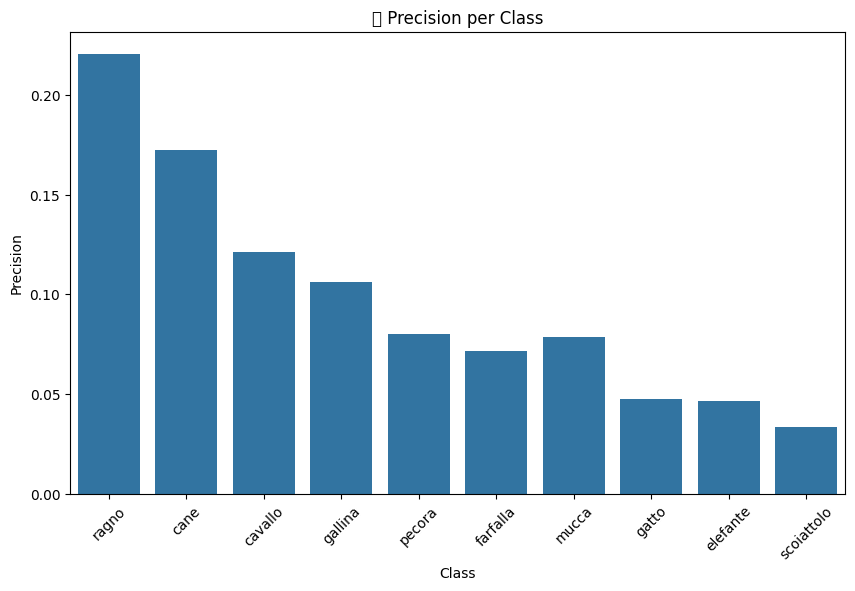

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


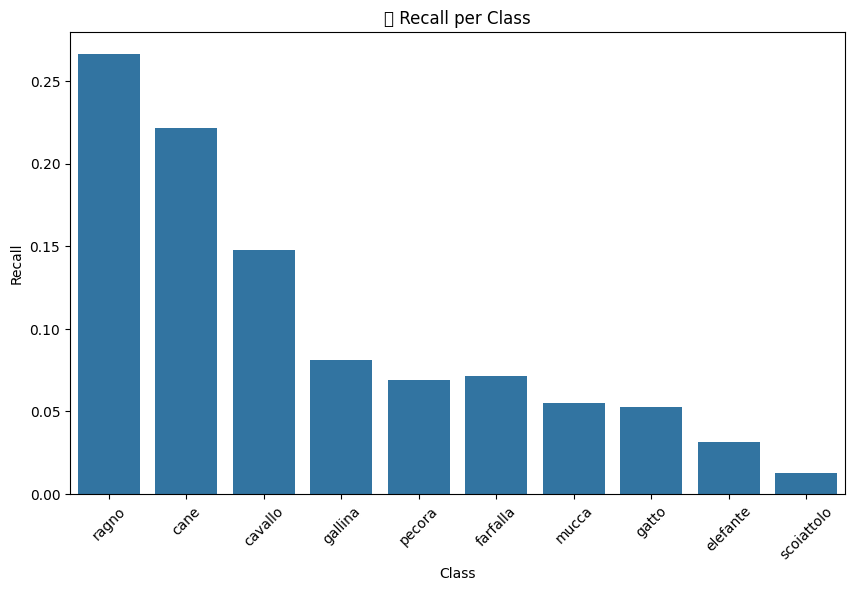

/tmp/ipython-input-3709639746.py:186: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3709639746.py:186: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


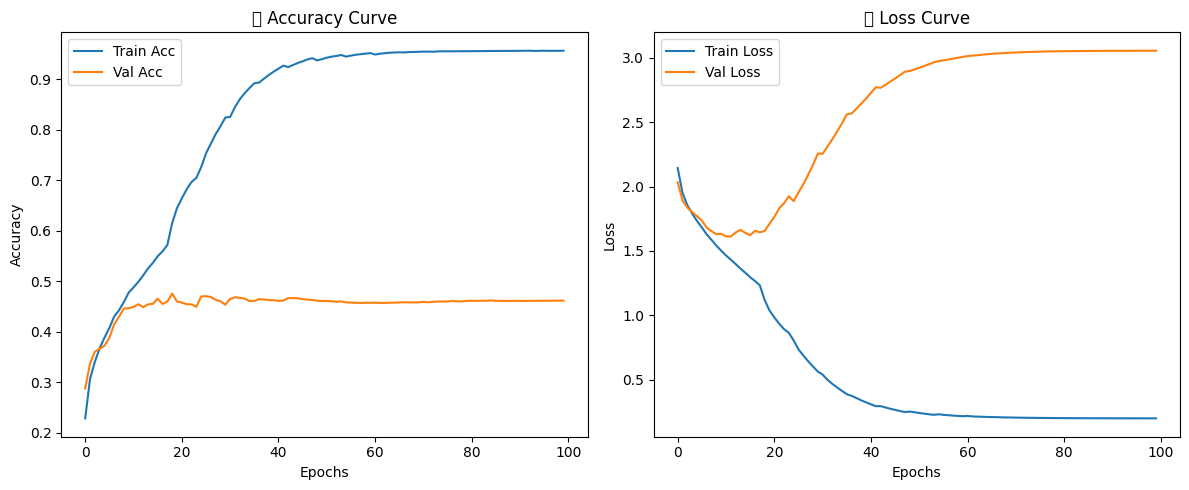

✅ Evaluation results saved to: /content/transformer_animals_h5/evaluation_metrics.csv


In [ ]:
# ===========================================
# 📊 Evaluation Metrics & Visualization
# For Vision Transformer — Animals10 Dataset
# ===========================================

import tensorflow as tf
from tensorflow import keras
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os, json
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# ---------------------------
# ⚙️ Paths
# ---------------------------
OUT = "/content/transformer_animals_h5"
DATA = "/content/animals10/raw-img"
IMG = 96
BATCH = 16

# ---------------------------
# 🧠 Load Classes
# ---------------------------
with open(f"{OUT}/classes.json", "r") as f:
    class_names = json.load(f)
nclass = len(class_names)
print(f"✅ Loaded {nclass} classes: {class_names}")

# ---------------------------
# 🧩 Reload Model with Custom Layers
# ---------------------------
from tensorflow.keras import layers

class GetItem(layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index
    def call(self, inputs):
        return inputs[:, self.index]

class PatchExtract(layers.Layer):
    def call(self, images):
        PATCH = 16
        patches = tf.image.extract_patches(
            images,
            sizes=[1, PATCH, PATCH, 1],
            strides=[1, PATCH, PATCH, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])

class PatchEncode(layers.Layer):
    def __init__(self, n=36, d=128, **kwargs):
        super().__init__(**kwargs)
        self.n = n
        self.d = d
        self.proj = layers.Dense(d)
    def build(self, input_shape):
        dtype = self.compute_dtype
        self.cls = self.add_weight(
            name="cls_token", shape=(1, 1, self.d),
            initializer="zeros", trainable=True, dtype=dtype)
        self.pos = self.add_weight(
            name="pos_embed", shape=(1, self.n + 1, self.d),
            initializer=keras.initializers.RandomNormal(stddev=0.02),
            trainable=True, dtype=dtype)
    def call(self, x):
        x = self.proj(x)
        cls = tf.broadcast_to(self.cls, [tf.shape(x)[0], 1, tf.shape(x)[-1]])
        x = tf.concat([cls, x], axis=1)
        return x + self.pos

MODEL_PATH = os.path.join(OUT, "best_val_model.h5")
model = keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "GetItem": GetItem,
        "PatchExtract": PatchExtract,
        "PatchEncode": PatchEncode
    }
)
print("✅ Model loaded successfully!")

# ---------------------------
# 🧩 Validation Dataset
# ---------------------------
val_ds = keras.utils.image_dataset_from_directory(
    DATA,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG, IMG),
    batch_size=BATCH
)
norm = keras.layers.Rescaling(1/255.)
val_ds = val_ds.map(lambda x, y: (norm(x), y))

# ---------------------------
# 📈 Evaluate
# ---------------------------
loss, acc = model.evaluate(val_ds, verbose=1)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print(f"✅ Validation Loss: {loss:.4f}")

# Predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_prob = model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# ---------------------------
# 📊 Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------------------------
# 🧾 Classification Report
# ---------------------------
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

# ---------------------------
# 📊 Precision, Recall, F1 Visualization
# ---------------------------
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(nclass))
metrics_df = pd.DataFrame({
    "Class": class_names,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}).sort_values("F1-Score", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Class", y="F1-Score", data=metrics_df)
plt.title("📈 F1-Score per Class")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="Class", y="Precision", data=metrics_df)
plt.title("🎯 Precision per Class")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="Class", y="Recall", data=metrics_df)
plt.title("📊 Recall per Class")
plt.xticks(rotation=45)
plt.show()

# ---------------------------
# 🕒 Training Curves (if CSV log exists)
# ---------------------------
log_path = os.path.join(OUT, "training_log.csv")
if os.path.exists(log_path):
    import pandas as pd
    log = pd.read_csv(log_path)
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(log["epoch"], log["accuracy"], label="Train Acc")
    plt.plot(log["epoch"], log["val_accuracy"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("📈 Accuracy Curve")

    # Loss
    plt.subplot(1,2,2)
    plt.plot(log["epoch"], log["loss"], label="Train Loss")
    plt.plot(log["epoch"], log["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("📉 Loss Curve")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ training_log.csv not found — skipped training curve plot.")

# ---------------------------
# 💾 Save Evaluation Results
# ---------------------------
report_df.to_csv(os.path.join(OUT, "evaluation_metrics.csv"))
print(f"✅ Evaluation results saved to: {OUT}/evaluation_metrics.csv")
